# Analyzing Data for wiu global-probe to cf worker

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import arff

## Import data set

In [2]:
# udpate for file import
timestamp = '2023-10-25-14-55' 
size = 100

# load data into pandas dataframe
file_name = 'data/{time}-s{size}.csv'.format(time=timestamp, size=str(size))
df = pd.read_csv(file_name)
df.head()

,responseCode,responseStatus,contentLength,serverIP,timingConnected,timingResponse,timingRequest,timingTransfer,location
0,200,OK,102400,104.21.71.190,0.099552,0.328982,0.329437,0.471010,accra
1,200,OK,102400,172.67.148.21,0.179761,1.227782,1.228638,1.358805,adelaide
2,200,OK,102400,172.67.148.21,0.005134,0.049605,0.050362,0.059554,albany
3,200,OK,102400,104.21.71.190,0.003082,0.033345,0.033594,0.038650,alblasserdam
4,200,OK,102400,104.21.71.190,0.021372,0.261122,0.261503,0.304756,albuquerque


## Normalize Data & Cleaning

In [3]:
# map location -> int (histogram)
location_to_int_mapping = {location: idx for idx, location in enumerate(df['location'].unique())}
df['location_int'] = df['location'].map(location_to_int_mapping)

# timing in ms
timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingConnected'])}
df['connected_time_ms'] = df['timingConnected'].map(timing_to_ms_mapping)

timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingResponse'])}
df['response_time_ms'] = df['timingResponse'].map(timing_to_ms_mapping)

timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingRequest'])}
df['request_time_ms'] = df['timingRequest'].map(timing_to_ms_mapping)

timing_to_ms_mapping = {timing: timing * 100 for _, timing in enumerate(df['timingTransfer'])}
df['transfer_time_ms'] = df['timingTransfer'].map(timing_to_ms_mapping)


df.head()

,responseCode,responseStatus,contentLength,serverIP,timingConnected,timingResponse,timingRequest,timingTransfer,location,location_int,connected_time_ms,response_time_ms,request_time_ms,transfer_time_ms
0,200,OK,102400,104.21.71.190,0.099552,0.328982,0.329437,0.471010,accra,0,9.9552,32.8982,32.9437,47.1010
1,200,OK,102400,172.67.148.21,0.179761,1.227782,1.228638,1.358805,adelaide,1,17.9761,122.7782,122.8638,135.8805
2,200,OK,102400,172.67.148.21,0.005134,0.049605,0.050362,0.059554,albany,2,0.5134,4.9605,5.0362,5.9554
3,200,OK,102400,104.21.71.190,0.003082,0.033345,0.033594,0.038650,alblasserdam,3,0.3082,3.3345,3.3594,3.8650
4,200,OK,102400,104.21.71.190,0.021372,0.261122,0.261503,0.304756,albuquerque,4,2.1372,26.1122,26.1503,30.4756


## Plot graphs
### 1.1 connected time VS location

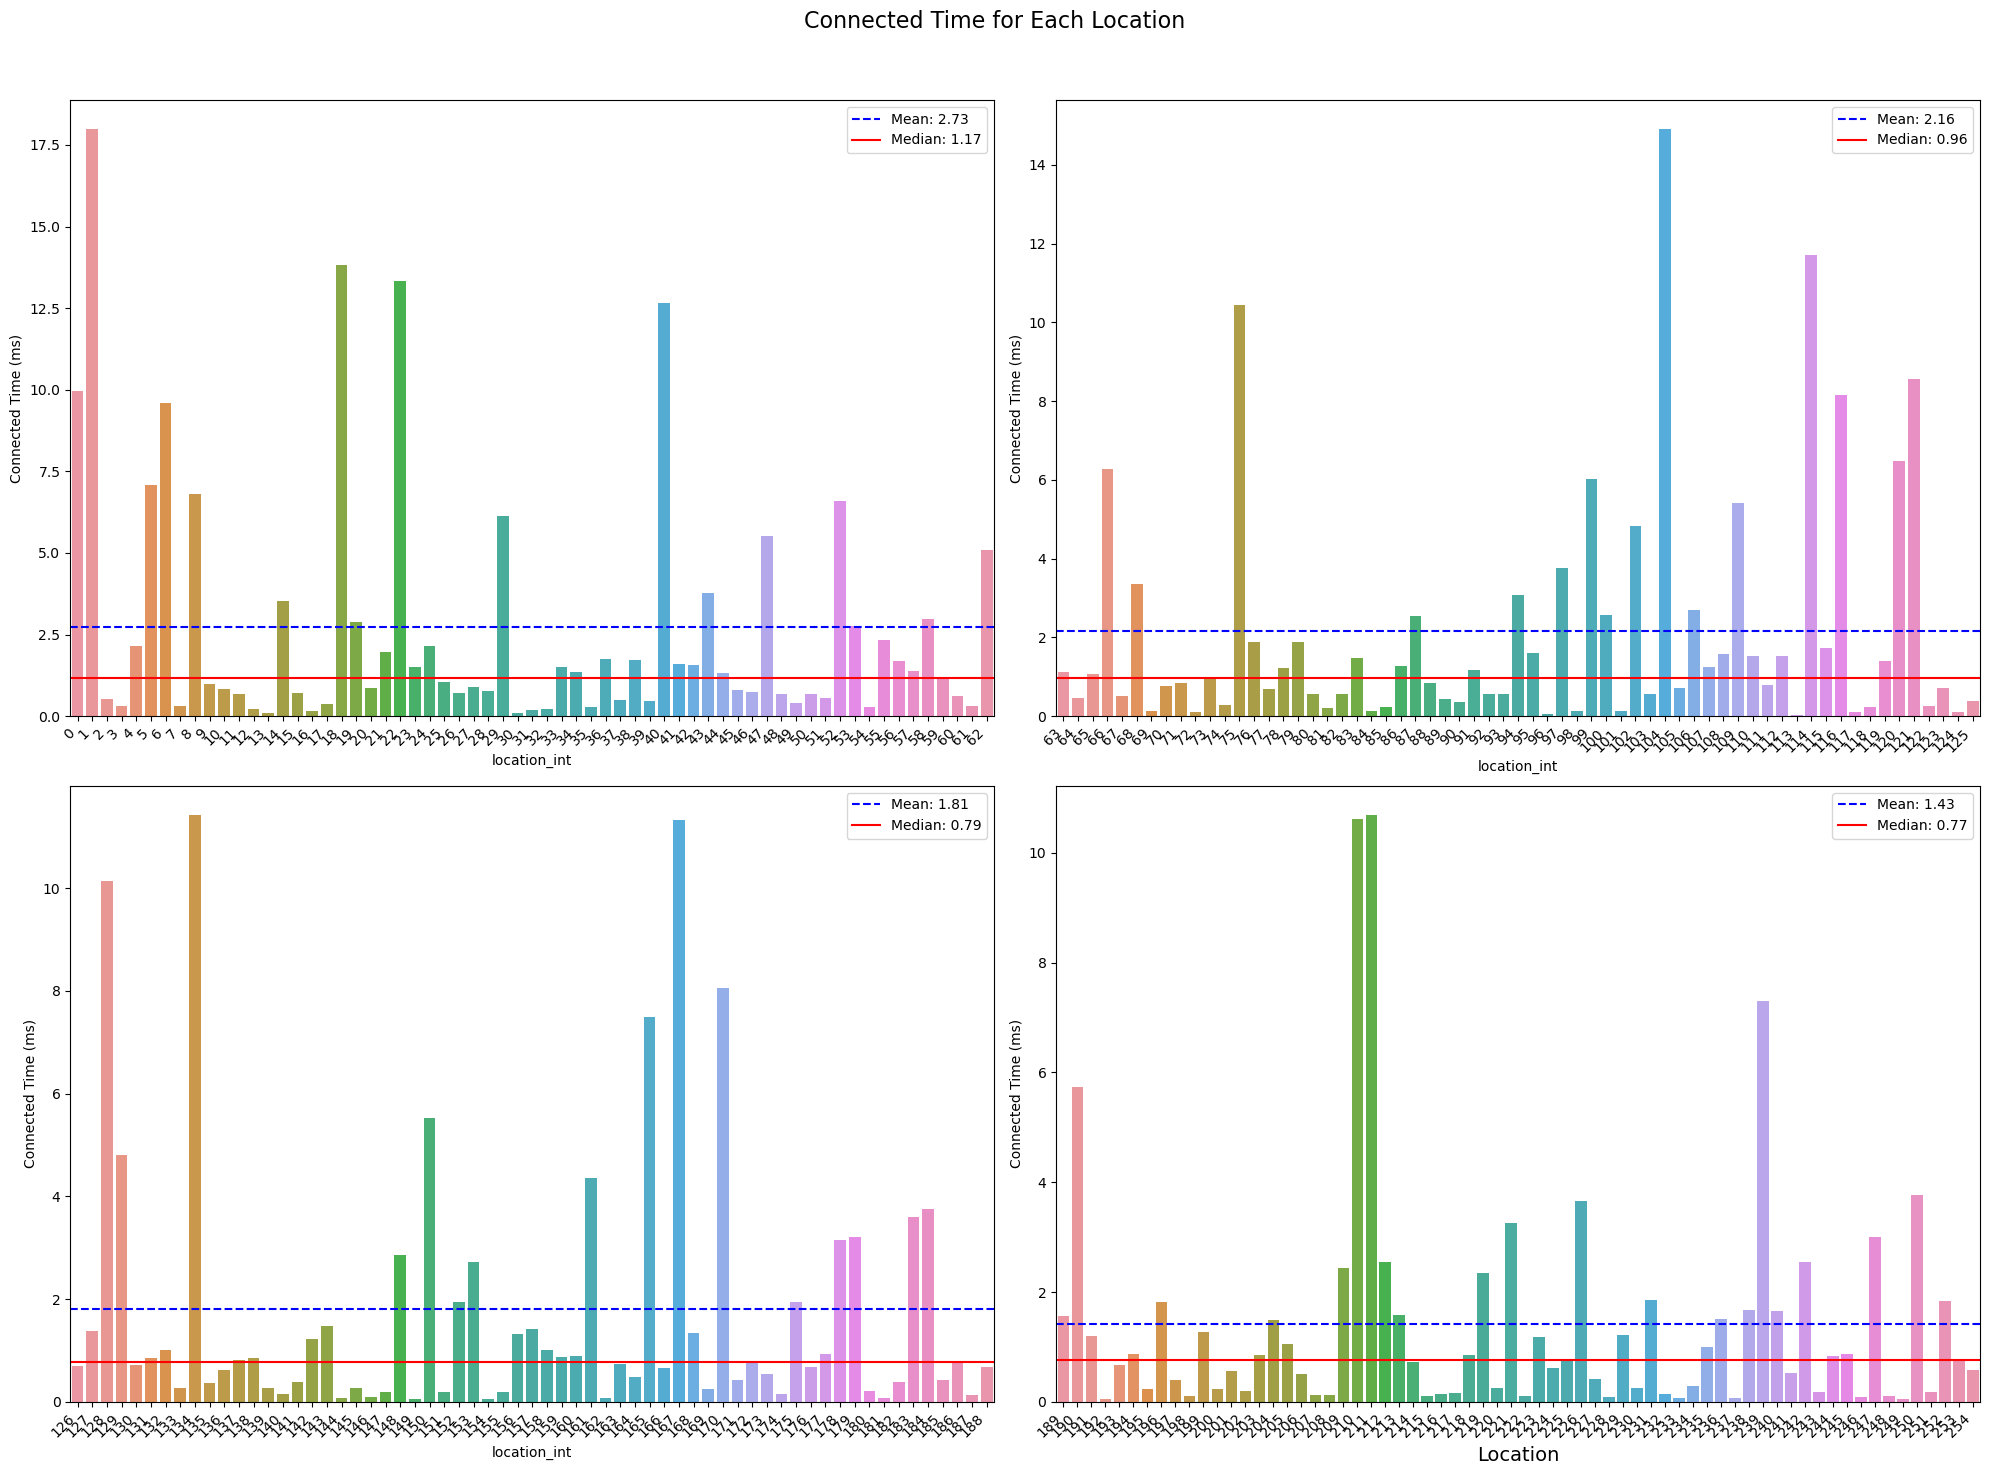

In [4]:
# Number of locations per subplot
num_locations = len(df) // 4

# Create a larger figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 15))  # adjust the size as needed
axs = axs.flatten()  # Flatten the 2x2 grid into a single list for easier indexing

for i in range(4):
    # Calculate the start and end indices for the data slice
    start_idx = i * num_locations
    end_idx = (i + 1) * num_locations if i != 3 else None  # go to the end for the last slice
    # Select the data slice
    df_slice = df.iloc[start_idx:end_idx]
    # Create the bar plot for this slice
    sns.barplot(data=df_slice, x='location_int', y='connected_time_ms', ax=axs[i])
    # Calculate mean and median
    mean_val = df_slice['connected_time_ms'].mean()
    median_val = df_slice['connected_time_ms'].median()
    # Add lines for mean and median
    axs[i].axhline(mean_val, color='blue', linestyle='--', label=f'Mean: {mean_val:.2f}')
    axs[i].axhline(median_val, color='red', linestyle='-', label=f'Median: {median_val:.2f}')
    
    # Set the legend
    axs[i].legend()

    # Rotate the x-axis labels for readability
    for label in axs[i].get_xticklabels():
        label.set_rotation(45)
        label.set_horizontalalignment('right')

    # Set the y-axis label
    axs[i].set_ylabel('Connected Time (ms)')

# Set the overall title and labels
fig.suptitle('Connected Time for Each Location', fontsize=16)
plt.xlabel('Location', fontsize=14)  # This sets label only for the last subplot

# Adjust layout and make sure the plots do not overlap
plt.tight_layout()
# Remember the overall title space
plt.subplots_adjust(top=0.92)

# Show the plot
plt.show()